# Paper numbers & figures

## Import libraries

In [1]:
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pysankey import sankey  # https://github.com/Pierre-Sassoulas/pySankey
from upsetplot import UpSet  # https://upsetplot.readthedocs.io/en/stable/index.html
from upsetplot import plot as UPplot
import yaml

pd.set_option("display.max_colwidth", None)

## Load data

All data files should be located in `../data/`

In [2]:
df = pd.DataFrame()
for repository in ["zenodo", "figshare", "osf"]:
    datasets = pd.read_csv(
        f"../data/{repository}_datasets.tsv",
        sep="\t",
        dtype={"dataset_id": str}
    )
    print(f"{repository}: found {datasets.shape[0]} datasets.")
    files = pd.read_csv(
        f"../data/{repository}_files.tsv",
        sep="\t",
        dtype={"dataset_id": str, "file_type": str,
               "file_md5": str, "file_url": str}
    )
    print(f"{repository}: found {files.shape[0]} files.")
    tab = pd.merge(files, datasets, how="left", on=["dataset_id", "dataset_origin"], validate="many_to_one")
    print(f"{repository}: merged dataframe has {tab.shape[0]} entries.\n")
    df = pd.concat([df, tab], ignore_index=True)

print(f"Dimensions of the final dataframe: {len(df)} lines (files) x {df.shape[1]} columns")

zenodo: found 981 datasets.
zenodo: found 153608 files.
zenodo: merged dataframe has 153608 entries.

figshare: found 901 datasets.
figshare: found 78954 files.
figshare: merged dataframe has 78954 entries.

osf: found 66 datasets.
osf: found 6133 files.
osf: merged dataframe has 6133 entries.

Dimensions of the final dataframe: 238695 lines (files) x 18 columns


## Assign year

In [3]:
df["year"] = df["date_creation"].apply(lambda x: int(x[:4]))

## Number of datasets and files by data repository

In [71]:
# Add columns for easier aggregation
df["_is_zip_file"] = np.where((df["file_type"] == "zip"), True, False)
df["_is_not_from_zip_file"] = ~ df["from_zip_file"]
df["_size_not_from_zip_file"] = np.where((df["from_zip_file"] == False), df["file_size"]/1E9, 0.0)
dataset_agg = (df
 .groupby("dataset_origin")
 .agg(
     number_of_datasets=("dataset_id", "nunique"),
     date_first_dataset=("date_creation", "min"),
     date_last_dataset=("date_creation", "max"),
     files_from_datasets=("_is_not_from_zip_file", "sum"),
     total_size_in_GB=("_size_not_from_zip_file", "sum"),
     zip_files=("_is_zip_file", "sum"),
     files_from_zip_files=("from_zip_file", "sum"),
     total_files=("dataset_id", "count")
 )
)
dataset_agg.loc["total"] = dataset_agg.sum(numeric_only=True)
dataset_agg.style.format(thousands=",", precision=0)

,number_of_datasets,date_first_dataset,date_last_dataset,files_from_datasets,total_size_in_GB,zip_files,files_from_zip_files,total_files
dataset_origin,,,,,,,,
figshare,901,2012-08-20,2023-01-12,"3,241",761,582,"75,713","78,954"
osf,59,2017-05-24,2023-01-08,"6,133",488,14,0,"6,133"
zenodo,981,2014-11-19,2023-01-16,"19,469","12,415","1,593","134,139","153,608"
total,"1,941",nan,nan,"28,843","13,664","2,189","209,852","238,695"


<div class="alert alert-info">
Files found in zip files are almost 8 times more numerous than files found directly in datasets.

In the following, we will considere all files (found directly in datasets and extracted from zip files).
</div>

In [72]:
(df
 .query("dataset_origin == 'osf'")
 .query("file_type == 'zip'")
)

,dataset_origin,dataset_id,file_type,file_size,file_md5,from_zip_file,file_name,file_url,origin_zip_file,doi,...,dataset_url,year,is_zip_file,is_not_from_zip_file,MD_engine,category,size_not_from_zip_file,_is_zip_file,_is_not_from_zip_file,_size_not_from_zip_file
232764,osf,gwem8,zip,4.644494e+06,af4e0524266a61ed8b8b14fb1f5fdb84,False,nonpolar oil on kerogen - trajectory.zip,https://osf.io/download/vkd7m/,none,NaN,...,https://osf.io/gwem8/,2019,True,True,Unknown,none,0.004644,True,True,0.004644
232765,osf,gwem8,zip,1.720148e+07,de319989d058b2909506830a708256e0,False,nonpolar oil on calcite - trajectory.zip,https://osf.io/download/f7tdq/,none,NaN,...,https://osf.io/gwem8/,2019,True,True,Unknown,none,0.017201,True,True,0.017201
232766,osf,gwem8,zip,1.714628e+07,0159286fd3603e7a0df79fd29011467d,False,polar oil on calcite - trajectory.zip,https://osf.io/download/yjk85/,none,NaN,...,https://osf.io/gwem8/,2019,True,True,Unknown,none,0.017146,True,True,0.017146
232769,osf,gwem8,zip,2.762333e+07,c6d63c9619ba0862187fc01f026b4fe9,False,polar oil on frozen kerogen - trajectory 1 (0.1 ns per 1ps).zip,https://osf.io/download/wbd9f/,none,NaN,...,https://osf.io/gwem8/,2019,True,True,Unknown,none,0.027623,True,True,0.027623
232771,osf,gwem8,zip,2.890354e+07,fd6206d1acf4cab5b8f9a2476d81eb04,False,polar oil on frozen kerogen - trajectory 2 (1 ns per 10ps).zip,https://osf.io/download/mekzu/,none,NaN,...,https://osf.io/gwem8/,2019,True,True,Unknown,none,0.028904,True,True,0.028904
232773,osf,gwem8,zip,4.411747e+07,26e82f5c2f52c7031bc957cdc80dce1e,False,polar oil on kerogen - trajectory.zip,https://osf.io/download/57xha/,none,NaN,...,https://osf.io/gwem8/,2019,True,True,Unknown,none,0.044117,True,True,0.044117
232911,osf,qdmpx,zip,4.002574e+09,8e47296a348e87626eaca8ee3c3b1da8,False,2. Structure Prediction/Input_files/HYBRIDIZE.zip,https://osf.io/download/xnkep/,none,NaN,...,https://osf.io/qdmpx/,2022,True,True,Unknown,none,4.002574,True,True,4.002574
232918,osf,qdmpx,zip,2.350958e+09,f9ee87ae21e13d1329f6d771cb17e0ea,False,3. Enhanced Sampling/awh_xvgs/XVGS.zip,https://osf.io/download/63970600e4687406049b46a6/,none,NaN,...,https://osf.io/qdmpx/,2022,True,True,Unknown,none,2.350958,True,True,2.350958
234705,osf,82n73,zip,2.692000e+03,3d7d7df74651f54990dbe7080b55d7a7,False,Homology Modeling/MODELLER_contents.zip,https://osf.io/download/a2nwe/,none,NaN,...,https://osf.io/82n73/,2017,True,True,Unknown,none,0.000003,True,True,0.000003
234707,osf,82n73,zip,3.973740e+06,52ff16e13139c275ae1a095ceb94fa35,False,Validation/RAMA-Py.zip,https://osf.io/download/fxjpk/,none,NaN,...,https://osf.io/82n73/,2017,True,True,Unknown,none,0.003974,True,True,0.003974


### Assign MD engine

In [8]:
file_types_list = []
with open("../params/file_types.yml", "r") as param_file:
    data_loaded = yaml.safe_load(param_file)
    file_types_list = data_loaded["file_types"]

    ext_gromacs = []
ext_namd = []
ext_amber = []
ext_charmm = []
ext_desmond = []

list_coordinate = []
list_trajectory = []
list_topology = []

for type_dict in file_types_list:
    # assign MD engine
    if type_dict["engine"] == "gromacs":
        ext_gromacs.append(type_dict["type"])
    elif type_dict["engine"] == "namd":
        ext_namd.append(type_dict["type"])
    elif type_dict["engine"] == "amber":
        ext_amber.append(type_dict["type"])
    elif type_dict["engine"] == "charmm":
        ext_charmm.append(type_dict["type"])
    elif type_dict["engine"] == "desmond":
        ext_desmond.append(type_dict["type"])
    # assign file category
    if type_dict["category"] == "coordinate":
        list_coordinate.append(type_dict["type"])
    elif type_dict["category"] == "topology":
        list_topology.append(type_dict["type"])
    elif type_dict["category"] == "trajectory":
        list_trajectory.append(type_dict["type"])

ext_all = ext_gromacs + ext_namd + ext_amber + ext_charmm
        
# The filetype "top" is included in both Gromacs and Amber. 
# And, the filetype "prm" is included in Namd and Amber.
# But, to simplify the analyses, I consider that "top" is only a filetype of Gromacs and prm a filetype of Namd.

def assign_md_engine(file_type):
    """Assign MD engine based on file type.
    
    Parameters
    ----------
    file_type : str
        File extension.
    
    Returns
    -------
    str
        Name of MD engine.
    """
    if file_type in ext_gromacs:
        return "GROMACS"
    elif file_type in (ext_namd + ext_charmm):
        return "NAMD/CHARMM"
    elif file_type in ext_amber:
        return "AMBER"
    elif file_type in ext_desmond:
        return "DESMOND"
    else:
        return "Unknown"

df["MD_engine"] = df["file_type"].apply(assign_md_engine)

### Number of datasets and files per MD engine

In [9]:
(df
 .groupby("MD_engine")
 .agg(
     datasets=("dataset_id", "nunique"),
     files=("dataset_id", "count")
 ).style.format(thousands=",", precision=0)
)

,datasets,files
MD_engine,,
AMBER,224,"9,803"
DESMOND,48,"1,855"
GROMACS,"1,228","83,552"
NAMD/CHARMM,660,"12,294"
Unknown,"1,137","131,191"


### Assign category

In [10]:
def assign_file_category(file_type):
    """Assign file category based on file type.
    
    Parameters
    ----------
    file_type : str
        File extension.
    
    Returns
    -------
    str
        Category.
    """
    if file_type in list_coordinate:
        return "coordinate"
    elif file_type in list_topology:
        return "topology"
    elif file_type in list_trajectory:
        return "trajectory"
    else:
        return "none"

df["category"] = df["file_type"].apply(assign_file_category)
df["category"].value_counts()

none          167179
trajectory     35321
topology       29476
coordinate      6719
Name: category, dtype: int64

## Figure 1

Evolution of number of “molecular dynamics” papers in PubMed vs time

See notebook `search_MD_in_pubmed.ipynb`.

## Figure 2

### 2.B. Evolution of the number MD files deposited in data repositories

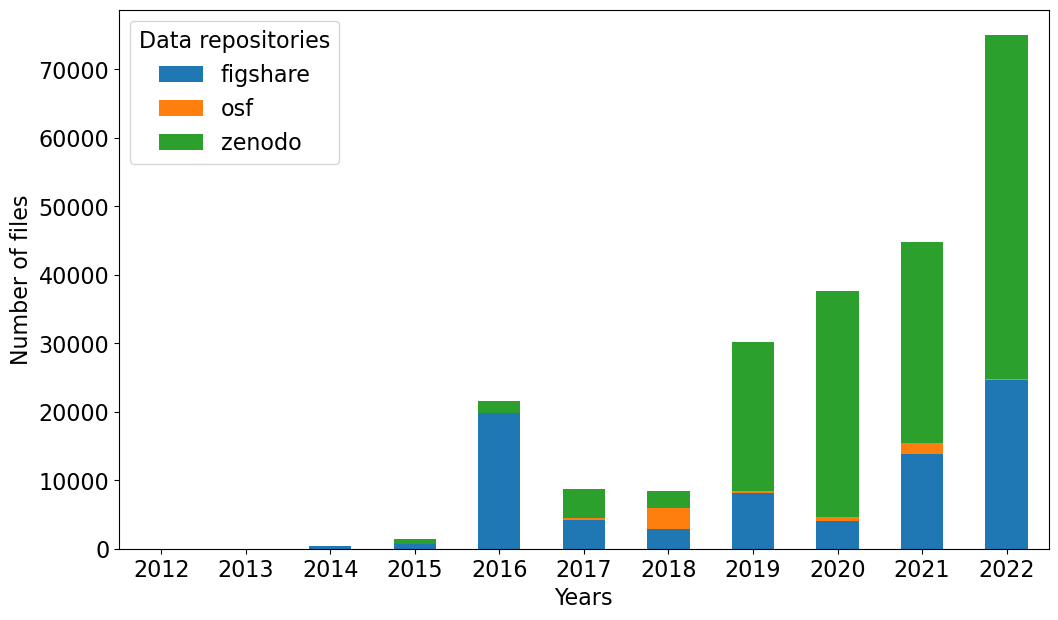

In [11]:
plt.rcParams.update({"font.size": 16})
(df
 .query("year != 2023")
 .groupby(["year", "dataset_origin"])
 .size().unstack()
 .plot(kind="bar", stacked=True, figsize=(12,7))
)
plt.xlabel("Years")
plt.xticks(rotation=0)
plt.ylabel("Number of files")
plt.legend(title="Data repositories")
filename = "fig/number_of_files_per_years_per_data_repositories"
plt.savefig(f"{filename}.png", dpi=300, bbox_inches="tight")
plt.savefig(f"{filename}.svg", bbox_inches="tight")

### 2.B. MD engines distribution

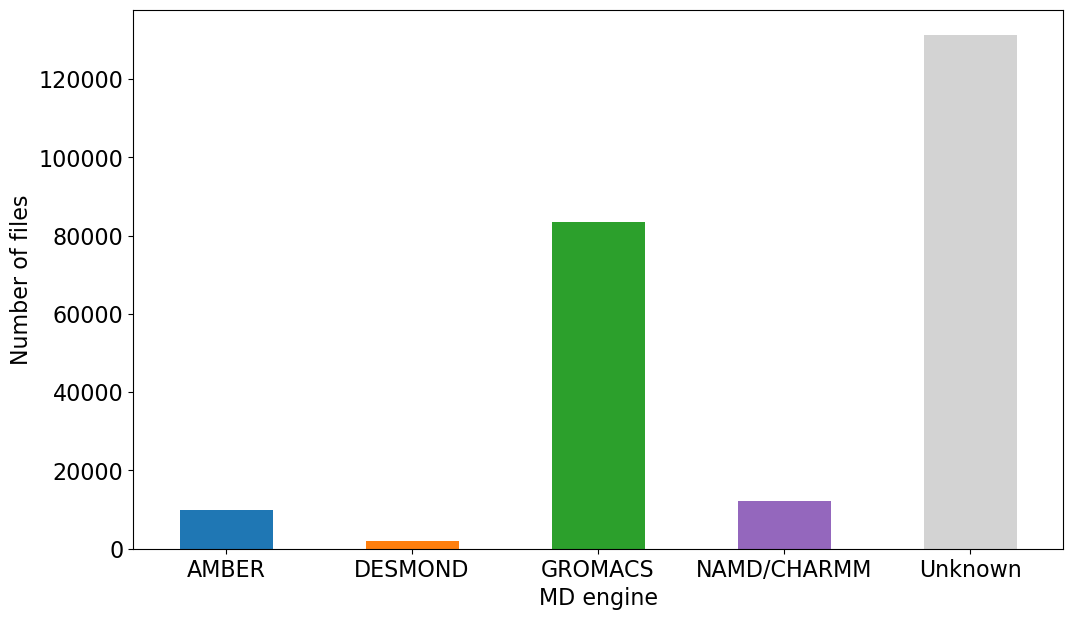

In [12]:
plt.rcParams.update({'font.size': 16})
(df
 .loc[:, "MD_engine"]
 .value_counts()
 .sort_index()
 .plot(kind="bar", color=["tab:blue", "tab:orange", "tab:green", "tab:purple", "lightgrey"], figsize=(12,7))
)
plt.xlabel("MD engine")
plt.xticks(rotation=0)
plt.ylabel("Number of files")
filename = "fig/number_of_files_per_MD_engine"
plt.savefig(f"{filename}.png", dpi=300, bbox_inches="tight")
plt.savefig(f"{filename}.svg", bbox_inches="tight")

### 2.C. Type of files not associated to any MD engine

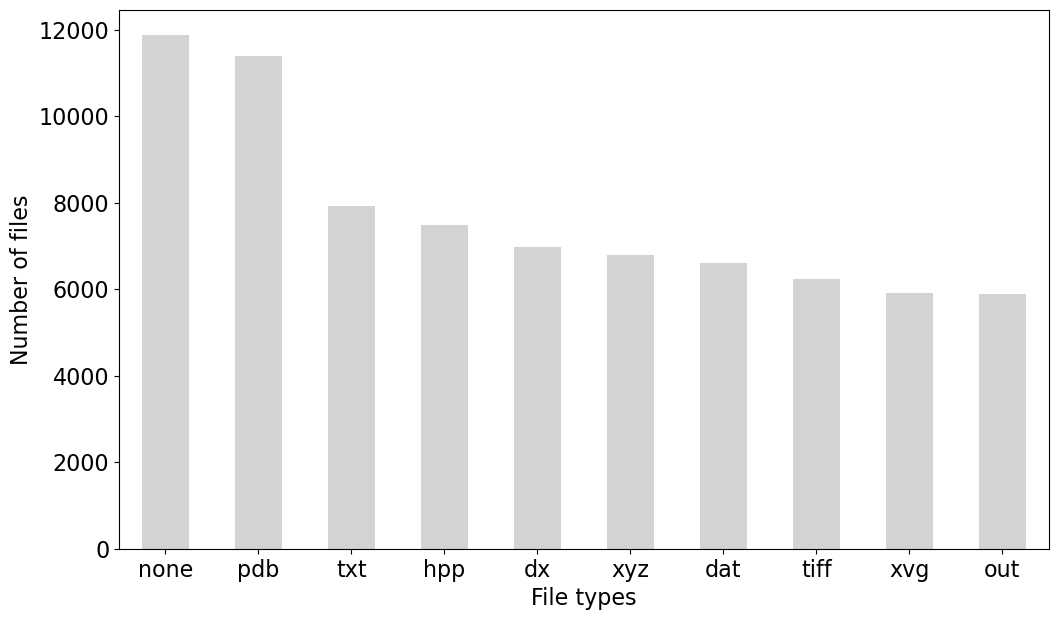

In [13]:
plt.rcParams.update({"font.size": 16})
(df
 .query("MD_engine == 'Unknown'")
 .loc[:, "file_type"]
 .value_counts()
 .head(n=10)
 .plot(kind="bar", color="lightgrey", figsize=(12,7))
)
plt.xlabel("File types")
plt.xticks(rotation=0)
plt.ylabel("Number of files")
filename = "fig/number_of_files_per_filetype_no_MD_engine"
plt.savefig(f"{filename}.png", dpi=300, bbox_inches="tight")
plt.savefig(f"{filename}.svg", bbox_inches="tight")

Most files with no file type are simulation snapshots, log or README files.

## Figure 3

### 3.A. Gromacs file types by categories

10 most frequent Gromacs file types

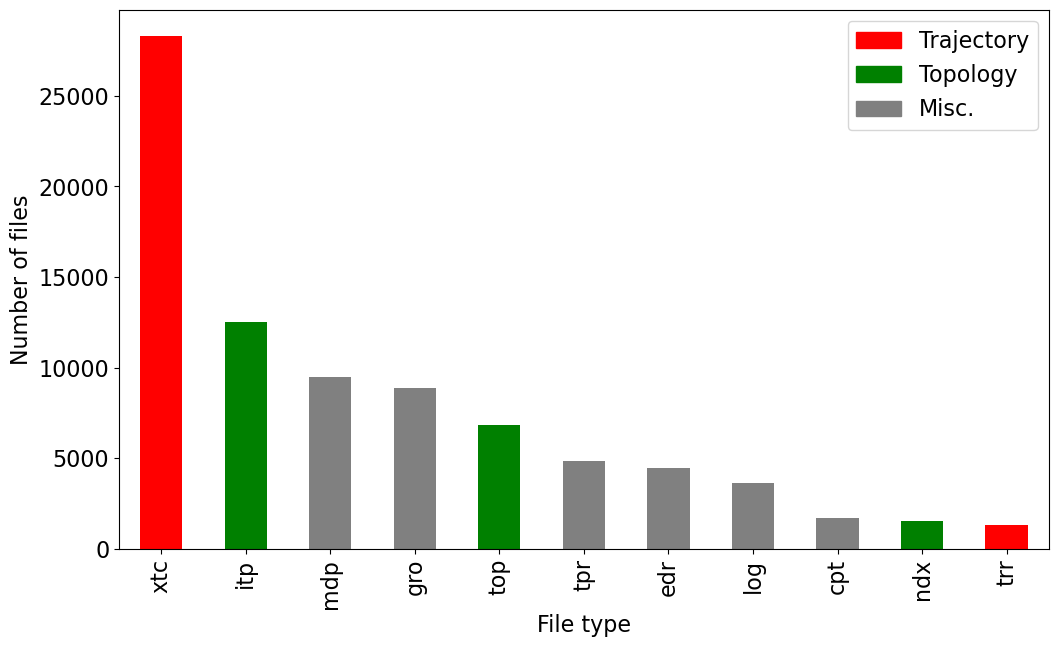

In [16]:
colors={
    "trajectory":"red",
    "topology":"green",
    "none":"grey"
}
gromacs_file_types = (df
 .query("MD_engine == 'GROMACS'")
 .groupby("file_type").agg({"category": "first", "file_name": "count"})
 .sort_values(by="file_name", ascending=False)
)
plt.rcParams.update({'font.size': 16})
gromacs_file_types["color"] = gromacs_file_types["category"].map(colors)
gromacs_file_types.plot(kind="bar", y="file_name", figsize=(12,7), color=gromacs_file_types["color"])
plt.xlabel("File type")
plt.ylabel("Number of files")
# Custom legend.
traj_patch = mpatches.Patch(color="red", label="Trajectory")
topol_patch = mpatches.Patch(color="green", label="Topology")
misc_patch = mpatches.Patch(color="grey", label="Misc.")
plt.legend(handles=[traj_patch, topol_patch, misc_patch])
filename = "fig/number_of_files_by_Gromacs_filetype"
plt.savefig(f"{filename}.png", dpi=300, bbox_inches="tight")
plt.savefig(f"{filename}.svg", bbox_inches="tight")

In [17]:
gromacs_files = df.query("MD_engine == 'GROMACS'")
print(
    f"Total of {gromacs_files.shape[0]} Gromacs files "
    f"from {gromacs_files['dataset_id'].nunique()} datasets."
)

Total of 83552 Gromacs files from 1228 datasets.


### 3.B. Cumulated distribution of gro files

In [18]:
gro_df = pd.read_csv("../data/gromacs_gro_files_info.tsv", sep="\t")
gro_df = pd.merge(
    gro_df,
    df[["dataset_origin", "dataset_id", "dataset_url"]].drop_duplicates(),
    on=["dataset_origin", "dataset_id"],
    how="left"
)
print(f"Dataset has {len(gro_df)} gro files")
gro_df.head()

Dataset has 10777 gro files


,dataset_origin,dataset_id,atom_number,has_protein,has_nucleic,has_lipid,has_water_ion,has_glucid,filename,dataset_url
0,osf,6fuqs,3468,True,False,False,False,False,Trajectories/4_su.gro,https://osf.io/6fuqs/
1,osf,6fuqs,3468,True,False,False,False,False,Trajectories/6_su.gro,https://osf.io/6fuqs/
2,osf,6fuqs,3468,True,False,False,False,False,Trajectories/3_su.gro,https://osf.io/6fuqs/
3,osf,6fuqs,3468,True,False,False,False,False,Trajectories/8_su.gro,https://osf.io/6fuqs/
4,osf,6fuqs,3468,True,False,False,False,False,Trajectories/2_su.gro,https://osf.io/6fuqs/


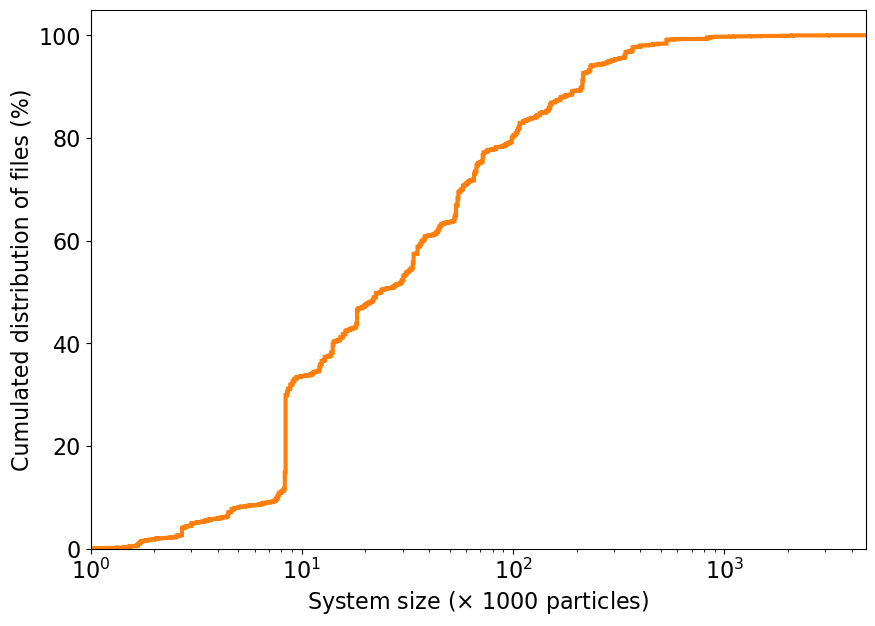

In [19]:
def plot_system_size_distribution(df):
    """Plot system size distribution"""
    # Convert system size to k-particules (1000) 
    df["k_particles"] = gro_df["atom_number"] / 1000

    logbins = np.geomspace(df["k_particles"].min()+1, df["k_particles"].max(), 1_000)

    plt.rcParams.update({"font.size": 16})
    fig, ax = plt.subplots(figsize=(10,7))
    values, bins, _ = ax.hist(
        df["k_particles"], 
        bins=logbins,
        color="tab:orange", linewidth=3,
        histtype="step", cumulative=True, density=True
    )
    ax.set_xlabel(r"System size ($\times$ 1000 particles)")
    ax.set_ylabel("Cumulated distribution of files (%)")
    ax.set_yticks(np.arange(0, 1.1, 0.2), [f"{value:.0f}" for value in np.arange(0, 1.1, 0.2)*100])
    ax.set_xscale("log")
    ax.set_xlim(1, df["k_particles"].max() - df["k_particles"].max()*0.1)
    filename = "fig/gromacs_gro_system_size_cumulated_distribution"
    plt.savefig(f"{filename}.png", dpi=300, bbox_inches="tight")
    plt.savefig(f"{filename}.svg", bbox_inches="tight")

plot_system_size_distribution(gro_df)

Smallest systems:

In [20]:
(gro_df
 .query("atom_number < 5")
 .sort_values(by="atom_number", ascending=True)
 #.to_csv("system_size_below_5_particles.tsv", sep="\t", index=False)
)

,dataset_origin,dataset_id,atom_number,has_protein,has_nucleic,has_lipid,has_water_ion,has_glucid,filename,dataset_url,k_particles
10269,figshare,8846045,2,False,False,False,False,False,Tutorial/gro/cell.gro,https://acs.figshare.com/articles/dataset/Nucleation_Mechanisms_of_Self-Assembled_Physisorbed_Monolayers_on_Graphite/8846045,0.002
9829,figshare,5190502,3,False,False,False,False,False,H2O_v2.gro,https://tandf.figshare.com/articles/dataset/Organic_and_Third_Phase_in_HNO_sub_3_sub_TBP_i_n_i_-Dodecane_System_No_Reverse_Micelles/5190502,0.003
10666,figshare,19534516,3,False,False,False,True,False,setup_files/2_packmol/H2O.gro,https://figshare.com/articles/dataset/All-atom_molecular_simulation_study_of_cellulose_acetate_amorphous_structure_and_the_dissolution_of_small_molecule/19534516,0.003
10668,figshare,19534516,3,False,False,False,False,False,setup_files/2_packmol/CO2.gro,https://figshare.com/articles/dataset/All-atom_molecular_simulation_study_of_cellulose_acetate_amorphous_structure_and_the_dissolution_of_small_molecule/19534516,0.003
10683,figshare,12517490,3,False,False,False,False,False,topolpgy_backmapping_files/topologies/Benzene/benzene_cg.gro,https://acs.figshare.com/articles/dataset/Capturing_Protein_Ligand_Recognition_Pathways_in_Coarse-Grained_Simulation/12517490,0.003
9879,figshare,11702442,4,False,False,False,False,False,ct9b01139_si_001/Topology_Files/AMMONIA/AMMONIA_GMX.gro,https://acs.figshare.com/articles/dataset/Alchemical_Hydration_Free-Energy_Calculations_Using_Molecular_Dynamics_with_Explicit_Polarization_and_Induced_Polarity_Decoupling_An_On_the_Fly_Polarization_Approach/11702442,0.004


Systems with about 1 k particles:

In [21]:
(gro_df
 .query("atom_number > 8_400")
 .query("atom_number < 8_500")
 .sort_values(by="atom_number", ascending=False)
 #.to_csv("system_size_between_8400_and_8500_particles.tsv", sep="\t", index=False)
)

,dataset_origin,dataset_id,atom_number,has_protein,has_nucleic,has_lipid,has_water_ion,has_glucid,filename,dataset_url,k_particles
1049,zenodo,4371296,8443,True,False,True,True,False,input_files/metad/SC-ANGLE/nterm/e0/equi.gro,https://zenodo.org/record/4371296,8.443
1604,zenodo,4371296,8443,True,False,True,True,False,input_files/umbrella/buf2_P11L/local/ins_ads/cterm+charge/19.gro,https://zenodo.org/record/4371296,8.443
1594,zenodo,4371296,8443,True,False,True,True,False,input_files/umbrella/buf2_P11L/local/ins_ads/cterm+charge/44.gro,https://zenodo.org/record/4371296,8.443
1595,zenodo,4371296,8443,True,False,True,True,False,input_files/umbrella/buf2_P11L/local/ins_ads/cterm+charge/40.gro,https://zenodo.org/record/4371296,8.443
1596,zenodo,4371296,8443,True,False,True,True,False,input_files/umbrella/buf2_P11L/local/ins_ads/cterm+charge/03.gro,https://zenodo.org/record/4371296,8.443
...,...,...,...,...,...,...,...,...,...,...,...
2080,zenodo,4371296,8428,True,False,True,True,False,input_files/umbrella/mag2/local/ins_ads/nterm/13.gro,https://zenodo.org/record/4371296,8.428
4753,zenodo,7061501,8415,True,False,True,True,False,Martini3_scaling/GpA/POPC/scaling_09/bilayer_assembly46.gro,https://zenodo.org/record/7061501,8.415
4853,zenodo,7061501,8415,True,False,True,True,False,Martini3_scaling/GpA/POPC/scaling_92/bilayer_assembly46.gro,https://zenodo.org/record/7061501,8.415
4943,zenodo,7061501,8415,True,False,True,True,False,Martini3_scaling/GpA/POPC/scaling_95/bilayer_assembly46.gro,https://zenodo.org/record/7061501,8.415


Largest systems:

In [22]:
(gro_df
 .query("atom_number > 2_000_000")
 .sort_values(by="atom_number", ascending=False)
 #.to_csv("system_size_above_5_000_000_particles.tsv", sep="\t", index=False)
)

,dataset_origin,dataset_id,atom_number,has_protein,has_nucleic,has_lipid,has_water_ion,has_glucid,filename,dataset_url,k_particles
9572,figshare,1238172,5184000,False,False,False,True,False,water01.gro,https://figshare.com/articles/dataset/water01_gro_Water_coordinate_file_for_cryo_EM_image_simulation/1238172,5184.000
3353,zenodo,3634884,3522816,True,False,True,True,False,PM_large_lastframe.noW.gro,https://zenodo.org/record/3634884,3522.816
7378,zenodo,6797842,3113594,True,False,True,True,False,simulations/protein_simulations/prepore/33mer_largemembrane/prepore_33mer_largemembrane_2200ns.gro,https://zenodo.org/record/6797842,3113.594
7379,zenodo,6797842,3113594,True,False,True,True,False,simulations/protein_simulations/prepore/33mer_largemembrane/prepore_33mer_largemembrane_equilibrated.gro,https://zenodo.org/record/6797842,3113.594
10157,figshare,14919822,2621751,True,False,False,True,False,Data_share/SMD_data/SMD_structure_data/OUTPUT/Spike_CR3022-4A8/Spike-4A8_1_pull_005.gro,https://acs.figshare.com/articles/dataset/Electrostatic_Interactions_Explain_the_Higher_Binding_Affinity_of_the_CR3022_Antibody_for_SARS-CoV_2_than_the_4A8_Antibody/14919822,2621.751
7364,zenodo,6797842,2125422,True,False,True,True,False,simulations/protein_simulations/pore/27mer/27mer_equilibrated.gro,https://zenodo.org/record/6797842,2125.422
7365,zenodo,6797842,2125422,True,False,True,True,False,simulations/protein_simulations/pore/27mer/27mer_4100ns.gro,https://zenodo.org/record/6797842,2125.422
7353,zenodo,6797842,2119785,True,False,True,True,False,simulations/protein_simulations/pore/33mer/33mer_equilibrated.gro,https://zenodo.org/record/6797842,2119.785
7354,zenodo,6797842,2119785,True,False,True,True,False,simulations/protein_simulations/pore/33mer/33mer_5000ns.gro,https://zenodo.org/record/6797842,2119.785
7355,zenodo,6797842,2119785,True,False,True,True,False,simulations/protein_simulations/pore/33mer/33mer_70C_1500ns.gro,https://zenodo.org/record/6797842,2119.785


### 3.C. System composition

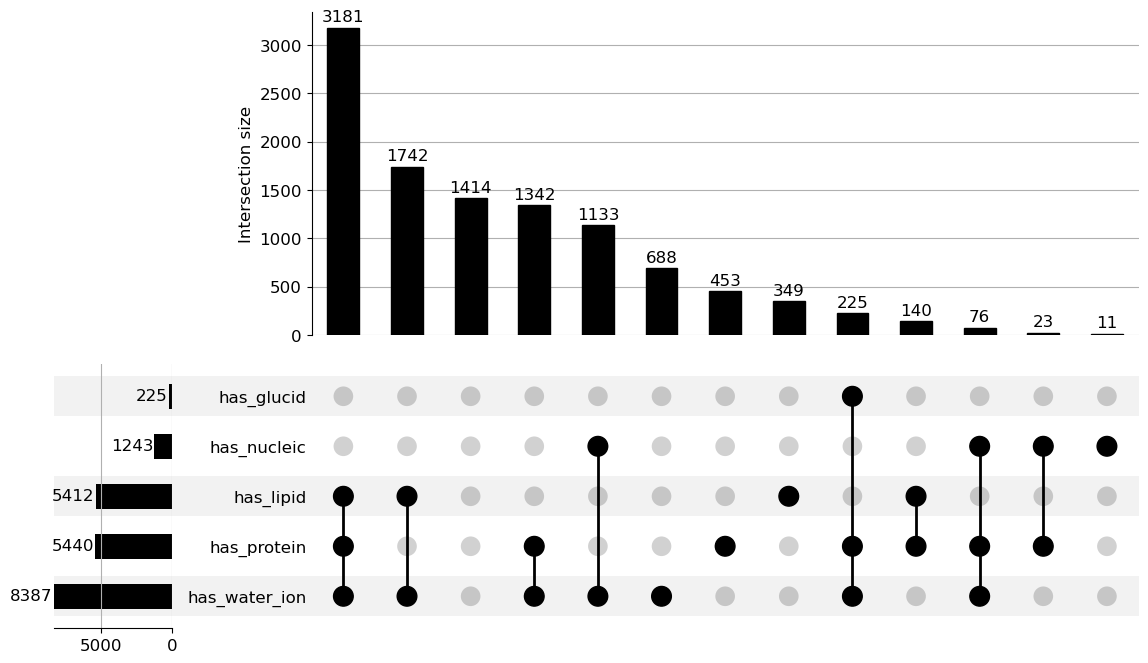

In [23]:
# Create pivot dataframe
df_upset = pd.pivot_table(
    gro_df, 
    index=["has_protein", "has_lipid", "has_nucleic", "has_water_ion", "has_glucid"], 
    values=["filename"], 
    aggfunc=len
)
# Convert pivot dataframe to Pandas Series with multi-index
sr_upset = pd.Series(index=df_upset.index, data=df_upset.values.flatten(), name="value")
plt.rcParams.update({"font.size": 12})
fig = plt.figure(figsize=(14, 8))
UPplot(sr_upset, fig=fig, show_counts=True, element_size=None, sort_by="cardinality")
filename = "fig/gromacs_system_composition"
plt.savefig(f"{filename}.png", dpi=300, bbox_inches="tight")
plt.savefig(f"{filename}.svg", bbox_inches="tight")

Systems without protein, lipid, nucleic acid, water, ion nor glucid:

In [24]:
(gro_df
 .query("has_protein == False")
 .query("has_water_ion == False")
 .query("has_lipid == False")
 .query("has_nucleic == False")
 .query("has_glucid == False")
 #.to_csv("systems_without_protein_water_ion_lipid_nucleic_acid_glucid.tsv", sep="\t", index=False)
)

,dataset_origin,dataset_id,atom_number,has_protein,has_nucleic,has_lipid,has_water_ion,has_glucid,filename,dataset_url,k_particles
76,osf,gwem8,780,False,False,False,False,False,non-polar oil cluster (30 octane molecules).gro,https://osf.io/gwem8/,0.780
77,osf,gwem8,18905,False,False,False,False,False,kerogen slab.gro,https://osf.io/gwem8/,18.905
78,osf,gwem8,8100,False,False,False,False,False,calcite (104).gro,https://osf.io/gwem8/,8.100
98,osf,yfstw,30,False,False,False,False,False,gros/LIP2.gro,https://osf.io/yfstw/,0.030
99,osf,yfstw,12,False,False,False,False,False,gros/C55P.gro,https://osf.io/yfstw/,0.012
...,...,...,...,...,...,...,...,...,...,...,...
10771,figshare,21726720,9,False,False,False,False,False,SI/1-1_PFOH.gro,https://acs.figshare.com/articles/dataset/Perfluorinated_Alcohols_at_High_Pressure_Experimental_Liquid_Density_and_Computer_Simulations/21726720,0.009
10772,figshare,21726720,21,False,False,False,False,False,SI/5-1_PFOH.gro,https://acs.figshare.com/articles/dataset/Perfluorinated_Alcohols_at_High_Pressure_Experimental_Liquid_Density_and_Computer_Simulations/21726720,0.021
10774,figshare,11569452,142,False,False,False,False,False,md_files/n-cage/conf.gro,https://acs.figshare.com/articles/dataset/Rationalizing_the_Activity_of_an_Artificial_Diels-Alderase_Establishing_Efficient_and_Accurate_Protocols_for_Calculating_Supramolecular_Catalysis/11569452,0.142
10775,figshare,11569452,5036,False,False,False,False,False,md_files/c-cage/solvated.gro,https://acs.figshare.com/articles/dataset/Rationalizing_the_Activity_of_an_Artificial_Diels-Alderase_Establishing_Efficient_and_Accurate_Protocols_for_Calculating_Supramolecular_Catalysis/11569452,5.036


## Figure 4

### 4.A. Simulation temperature

In [25]:
mdp_df = pd.read_csv("../data/gromacs_mdp_files_info.tsv", sep="\t")
mdp_df = pd.merge(
    mdp_df,
    df[["dataset_origin", "dataset_id", "dataset_url"]].drop_duplicates(),
    on=["dataset_origin", "dataset_id"],
    how="left"
)
print(f"Dataset has {len(mdp_df)} mdp files")
mdp_df.head()

Dataset has 11295 mdp files


,dataset_origin,dataset_id,dt,nsteps,temperature,barostat,thermostat,filename,dataset_url
0,osf,2ah8r,0.001,2500000.0,303.15,NaN,berendsen,step6.2_equilibration.mdp,https://osf.io/2ah8r/
1,osf,2ah8r,0.002,5000000.0,303.15,berendsen,berendsen,step6.4_equilibration.mdp,https://osf.io/2ah8r/
2,osf,2ah8r,0.001,2500000.0,303.15,berendsen,berendsen,step6.3_equilibration.mdp,https://osf.io/2ah8r/
3,osf,2ah8r,0.002,5000000.0,303.15,berendsen,berendsen,step6.6_equilibration.mdp,https://osf.io/2ah8r/
4,osf,2ah8r,0.002,100000000.0,303.15,Parrinello-Rahman,Nose-Hoover,step7_production.mdp,https://osf.io/2ah8r/


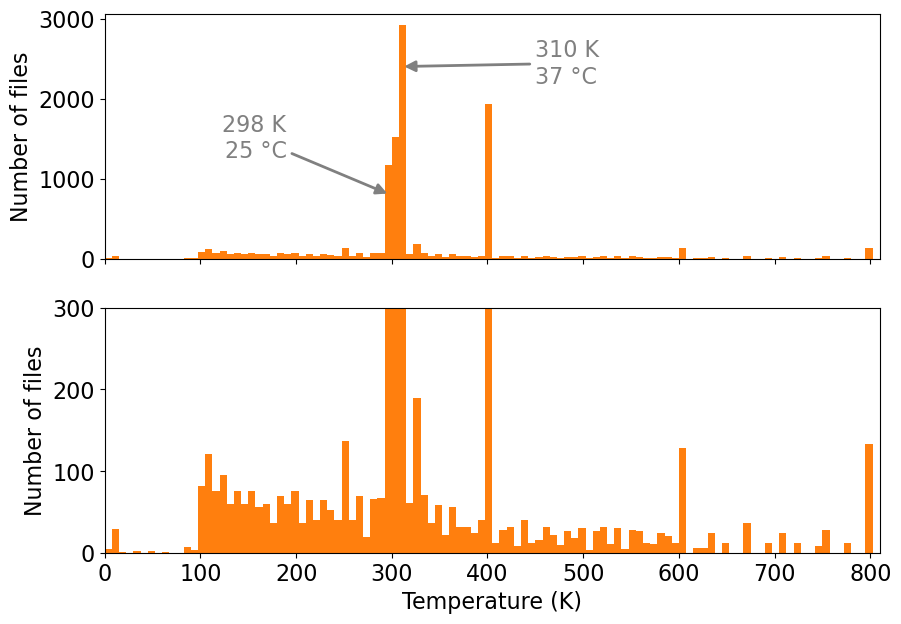

In [26]:
def plot_temperature_histogram(df):
    """Create plot for temperature distribution"""
    bins=200
    plt.rcParams.update({"font.size": 16})
    fig, ax = plt.subplots(2, sharex=True, figsize=(10,7))
    ax[0].hist(df["temperature"], bins=bins, color="tab:orange")
    ax[0].set_ylabel("Number of files")
    ax[0].set_xlim(0, 810)
    ax[0].annotate("310 K\n37 °C", xy=(310, 2400), xytext=(450, 2750), color="gray",
                 arrowprops={"arrowstyle":"-|>", "lw":2, "color":"gray", "connectionstyle":"arc3"}, 
                 horizontalalignment="left", verticalalignment="top")
    ax[0].annotate("298 K\n25 °C", xy=(298, 800), xytext=(190, 1200), color="gray",
                 arrowprops={"arrowstyle":"-|>", "lw":2, "color":"gray"}, 
                 horizontalalignment="right", verticalalignment="bottom")

    ax[1].hist(df["temperature"], bins=bins, color="tab:orange")
    ax[1].set_ylabel("Number of files")
    ax[1].set_ylim(0, 300)
    ax[1].set_xlabel("Temperature (K)")
    filename = "fig/gromacs_temperature_histogram"
    plt.savefig(f"{filename}.png", dpi=300, bbox_inches="tight")
    plt.savefig(f"{filename}.svg", bbox_inches="tight")

plot_temperature_histogram(mdp_df)

### Systems with lowest temperatures

In [27]:
(mdp_df
 .query("temperature < 15")
 .sort_values(by="temperature", ascending=True)
 .head(10)
)

,dataset_origin,dataset_id,dt,nsteps,temperature,barostat,thermostat,filename,dataset_url
5021,figshare,7370684,0.0020,5000.0,0.0,no,v-rescale,md_files/2-MD-runs/mdp/1_grompp_minimisation.mdp,https://acs.figshare.com/articles/dataset/Stereospecific_1_3_H_Transfer_of_Indenols_Proceeds_via_Persistent_Ion-Pairs_Anchored_by_NH__Interactions/7370684
5786,figshare,8846045,0.0300,10000.0,0.0,berendsen,Berendsen,Tutorial/mdp/2_npt.mdp,https://acs.figshare.com/articles/dataset/Nucleation_Mechanisms_of_Self-Assembled_Physisorbed_Monolayers_on_Graphite/8846045
5788,figshare,8846045,0.0300,1000000.0,0.0,berendsen,Berendsen,Tutorial/mdp/3_run.mdp,https://acs.figshare.com/articles/dataset/Nucleation_Mechanisms_of_Self-Assembled_Physisorbed_Monolayers_on_Graphite/8846045
5789,figshare,8846045,0.0300,5000.0,0.0,no,Berendsen,Tutorial/mdp/2_nvt.mdp,https://acs.figshare.com/articles/dataset/Nucleation_Mechanisms_of_Self-Assembled_Physisorbed_Monolayers_on_Graphite/8846045
5486,figshare,10269416,0.0005,60000000.0,3.0,Parrinello-Rahman,nose-hoover,input_files/MD/production_REMD.mdp,https://acs.figshare.com/articles/dataset/Adding_Anisotropy_to_the_Standard_Quasi-Harmonic_Approximation_Still_Fails_in_Several_Ways_to_Capture_Organic_Crystal_Thermodynamics/10269416
9144,figshare,21644393,0.0010,5000000.0,10.0,berendsen,berendsen,SI/Carbamazepine/GAFFTIP3P/formI/Freeze_10/equilibration.mdp,https://acs.figshare.com/articles/dataset/A_Comparison_of_Methods_for_Computing_Relative_Anhydrous_Hydrate_Stability_with_Molecular_Simulation/21644393
9293,figshare,21644393,0.0010,0.0,10.0,berendsen,berendsen,SI/Carbamazepine/GAFFTIP3P/CarbamazepineLiq48/Freeze_10/production.mdp,https://acs.figshare.com/articles/dataset/A_Comparison_of_Methods_for_Computing_Relative_Anhydrous_Hydrate_Stability_with_Molecular_Simulation/21644393
9294,figshare,21644393,0.0010,5000000.0,10.0,berendsen,berendsen,SI/Carbamazepine/GAFFTIP3P/CarbamazepineLiq48/Freeze_10/equilibration.mdp,https://acs.figshare.com/articles/dataset/A_Comparison_of_Methods_for_Computing_Relative_Anhydrous_Hydrate_Stability_with_Molecular_Simulation/21644393
9443,figshare,21644393,0.0010,0.0,10.0,berendsen,berendsen,SI/Carbamazepine/GAFFTIP3P/dihydrate/Freeze_10/production.mdp,https://acs.figshare.com/articles/dataset/A_Comparison_of_Methods_for_Computing_Relative_Anhydrous_Hydrate_Stability_with_Molecular_Simulation/21644393
9444,figshare,21644393,0.0010,5000000.0,10.0,berendsen,berendsen,SI/Carbamazepine/GAFFTIP3P/dihydrate/Freeze_10/equilibration.mdp,https://acs.figshare.com/articles/dataset/A_Comparison_of_Methods_for_Computing_Relative_Anhydrous_Hydrate_Stability_with_Molecular_Simulation/21644393


### Focus on the spikes at 400, 600 & 800 K

In [38]:
(mdp_df
 .query("temperature == 400 | temperature == 600 | temperature == 800")
 .groupby(["dataset_origin", "dataset_id"])
 .size()
)

dataset_origin  dataset_id
figshare        21644393      2160
                4040661          1
                6384443          2
zenodo          20544            3
dtype: int64

We dig more with dataset 21644393:

In [42]:
(mdp_df
 .query("dataset_id == '21644393'")
 .value_counts(subset="temperature")
 .head()
)

temperature
400.0    1924
300.0     256
600.0     128
800.0     108
250.0      96
dtype: int64

Dataset [21644393](https://acs.figshare.com/articles/dataset/A_Comparison_of_Methods_for_Computing_Relative_Anhydrous_Hydrate_Stability_with_Molecular_Simulation/21644393) in Figshare:
> A Comparison of Methods for Computing Relative Anhydrous–Hydrate Stability with Molecular Simulation

This dataset has actually far more mdp files:

In [45]:
(mdp_df
 .query("dataset_id == '21644393'")
 .shape[0]
)

5256

5256 mdp files for a single dataset!

### Hightest temperatures

In [28]:
mdp_df.query("temperature > 800")

,dataset_origin,dataset_id,dt,nsteps,temperature,barostat,thermostat,filename,dataset_url
5074,figshare,2267512,0.001,6000000.0,1500.0,no,V-rescale,6P_crystal_reproduction_files/reproduction_files/NVT/nvt_annealing.mdp,https://acs.figshare.com/articles/dataset/Growth_and_Characterization_of_Molecular_Crystals_of_i_para_i_Sexiphenyl_by_All_Atom_Computer_Simulations/2267512


Dataset [2267512](https://figshare.com/articles/dataset/Growth_and_Characterization_of_Molecular_Crystals_of_i_para_i_Sexiphenyl_by_All_Atom_Computer_Simulations/2267512) at 1500 K:

> Growth and Characterization of Molecular Crystals of para-Sexiphenyl by All-Atom Computer Simulations

## 4.B. Cumulated distribution of simulation time

In [29]:
# Compute simulation time:
# dt is in ps
# https://manual.gromacs.org/documentation/current/user-guide/mdp-options.html#mdp-dt
mdp_df["time"] = mdp_df["dt"] * mdp_df["nsteps"] / 1000
# in ns
# 1 µs = 1 000 ns

# Attribute all-atom (AA) or corase-grain (CG) simulation type
mdp_df["simulation_type"] = np.where(mdp_df["dt"] <= 0.01, "AA", "GG")

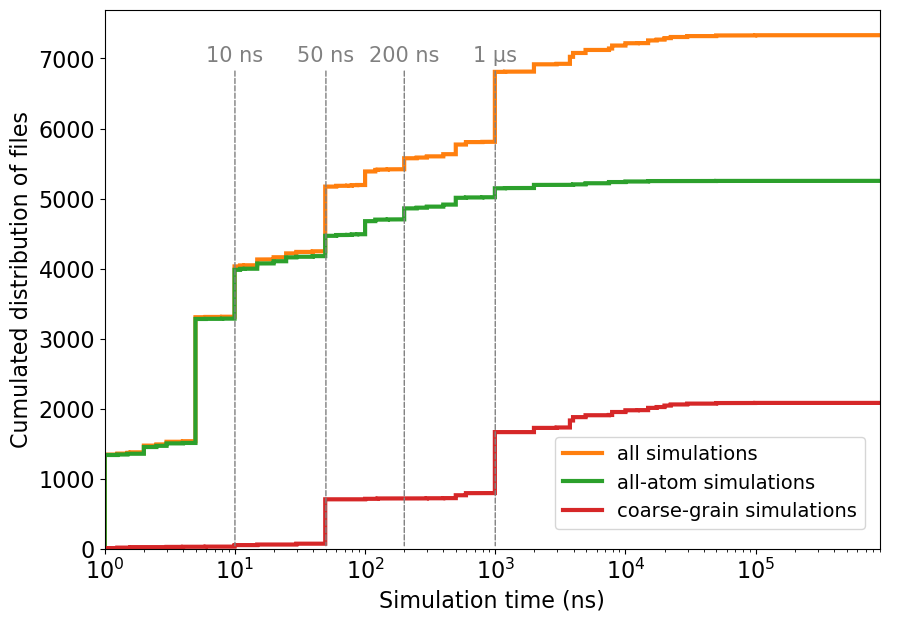

In [30]:
def plot_simulation_time_distribution(df):
    logbins = np.geomspace(df["time"].min()+1, df["time"].max(), 1_000)

    plt.rcParams.update({"font.size": 16})
    fig, ax = plt.subplots(figsize=(10,7))
    values, bins, _ = ax.hist(
        df["time"], 
        bins=logbins,
        color="tab:orange", linewidth=3,
        histtype="step", cumulative=True,
        label = "all simulations"
    )
    values, bins, _ = ax.hist(
        df[ df["simulation_type"] == "AA" ]["time"], 
        bins=logbins,
        color="tab:green", linewidth=3,
        histtype="step", cumulative=True,
        label = "all-atom simulations"
    )
    values, bins, _ = ax.hist(
        df[ df["simulation_type"] == "GG" ]["time"], 
        bins=logbins,
        color="tab:red", linewidth=3,
        histtype="step", cumulative=True,
        label = "coarse-grain simulations"
    )
    ax.set_xlabel("Simulation time (ns)")
    ax.set_ylabel("Cumulated distribution of files")
    ax.set_xscale("log")
    ax.set_xlim(1, df["time"].max() - df["time"].max() * 0.1)
    ax.annotate("10 ns", xy=(10, 0), xytext=(10, 6900), color="gray",
                 arrowprops={"arrowstyle":"-", "linestyle":"--", "lw":1, "color":"gray"}, 
                 horizontalalignment="center", verticalalignment="bottom", fontsize=15)
    ax.annotate("50 ns", xy=(50, 0), xytext=(50, 6900), color="gray",
                 arrowprops={"arrowstyle":"-", "linestyle":"--", "lw":1, "color":"gray"}, 
                 horizontalalignment="center", verticalalignment="bottom", fontsize=15)
    ax.annotate("200 ns", xy=(200, 0), xytext=(200, 6900), color="gray",
                 arrowprops={"arrowstyle":"-", "linestyle":"--", "lw":1, "color":"gray"}, 
                 horizontalalignment="center", verticalalignment="bottom", fontsize=15)
    ax.annotate("1 µs", xy=(1000, 0), xytext=(1000, 6900), color="gray",
                 arrowprops={"arrowstyle":"-", "linestyle":"--", "lw":1, "color":"gray"}, 
                 horizontalalignment="center", verticalalignment="bottom", fontsize=15)
    legend_elements = [
        Line2D([0], [0], color="tab:orange", lw=3, label="all simulations"),
        Line2D([0], [0], color="tab:green", lw=3, label="all-atom simulations"),
        Line2D([0], [0], color="tab:red", lw=3, label="coarse-grain simulations")
    ]                   
    fig.legend(handles=legend_elements, loc=(0.61, 0.15), prop={"size":14})
    filename = "fig/gromacs_simulation_time"
    plt.savefig(f"{filename}.png", dpi=300, bbox_inches="tight")
    plt.savefig(f"{filename}.svg", bbox_inches="tight")

plot_simulation_time_distribution(mdp_df)

### Simulations above 50 µs

In [31]:
mdp_df.query("time >= 50_000")

,dataset_origin,dataset_id,dt,nsteps,temperature,barostat,thermostat,filename,dataset_url,time,simulation_type
207,osf,a43z2,0.030,2.500000e+09,310.0,parrinello-rahman,v-rescale,hGBP1 dimer Martini-MD/cg_md_dimer_traj.mdp,https://osf.io/a43z2/,75000.0,GG
370,zenodo,4451274,0.002,5.000000e+10,310.0,Berendsen,No,SARS-COV2_spike_simulations_Dform_Gform/md.mdp,https://zenodo.org/record/4451274,100000.0,AA
493,zenodo,4116245,0.020,2.500000e+09,310.0,Parrinello-Rahman,V-rescale,md.mdp,https://zenodo.org/record/4116245,50000.0,GG
517,zenodo,7457014,0.020,2.500000e+09,310.0,parrinello-rahman,v-rescale,parameter_files/20fs_prod_nopull.mdp,https://zenodo.org/record/7457014,50000.0,GG
518,zenodo,7457014,0.020,2.500000e+09,310.0,parrinello-rahman,v-rescale,parameter_files/20fs_prod.mdp,https://zenodo.org/record/7457014,50000.0,GG
2411,zenodo,7017263,0.002,5.000000e+11,300.0,Parrinello-Rahman,V-rescale,degrader-ternary-complex-prediction-paper-final/hremd/scripts/config/md.mdp,https://zenodo.org/record/7017263,1000000.0,AA
3387,zenodo,4115972,0.020,2.500000e+09,310.0,Parrinello-Rahman,V-rescale,md.mdp,https://zenodo.org/record/4115972,50000.0,GG
3432,zenodo,846428,0.020,5.000000e+09,315.0,Parrinello-rahman,v-rescale,md.mdp,https://zenodo.org/record/846428,100000.0,GG
3815,zenodo,4115152,0.020,2.500000e+09,310.0,Parrinello-Rahman,V-rescale,md.mdp,https://zenodo.org/record/4115152,50000.0,GG
4554,zenodo,4445375,0.025,2.000000e+09,310.0,berendsen,V-rescale,md.mdp,https://zenodo.org/record/4445375,50000.0,GG


### Proportions of AT/CG simulations

In [32]:
# Below 1 µs
(mdp_df
 .query("time < 1_000")
 .value_counts(subset="simulation_type", normalize=True)
)

simulation_type
AA    0.892701
GG    0.107299
dtype: float64

In [33]:
# Above 1 µs
(mdp_df
 .query("time >= 1_000")
 .value_counts(subset="simulation_type", normalize=True)
)

simulation_type
GG    0.845699
AA    0.154301
dtype: float64

In [34]:
# Above 10 µs
(mdp_df
 .query("time >= 10_000")
 .value_counts(subset="simulation_type", normalize=True)
)

simulation_type
GG    0.878378
AA    0.121622
dtype: float64

## 4.C. Thermostat and barostat combinaison

In [35]:
# Mdp files without thermostat
print(mdp_df[ mdp_df["thermostat"].isna() ].shape[0])
mdp_df[ mdp_df["thermostat"].isna() ].head()

728


,dataset_origin,dataset_id,dt,nsteps,temperature,barostat,thermostat,filename,dataset_url,time,simulation_type
5,osf,2ah8r,NaN,5000.0,NaN,NaN,NaN,step6.0_minimization.mdp,https://osf.io/2ah8r/,NaN,GG
14,osf,82n73,NaN,5000.0,NaN,NaN,NaN,Research Projects/HIV gp41 TMD - Biophysical Journal/mdp_restraint_files/step6.0_minimization.mdp,https://osf.io/82n73/,NaN,GG
22,osf,82n73,NaN,5000.0,NaN,NaN,NaN,Research Projects/HIV GP41 MPER-TMD-CT JACS 2021/mdps/step6.0_minimization.mdp,https://osf.io/82n73/,NaN,GG
27,osf,82n73,NaN,5000000.0,NaN,NaN,NaN,Research Projects/IAPP(20-29) + Small Molecules - ACS Neuro (2022)/Parameter files/em.mdp,https://osf.io/82n73/,NaN,GG
29,osf,82n73,NaN,50000.0,NaN,NaN,NaN,Research Projects/IAPP(20-29) + Small Molecules - ACS Neuro (2022)/Parameter files/ions.mdp,https://osf.io/82n73/,NaN,GG


In [36]:
# Clean barostat and thermostat names
thermostats = {
    "berendsen": "Berendsen",
    "nosehoover": "Nose-Hoover",
    "vrescale": "V-rescale",
    "no": "No temperature"
}
# Add a space after Berendsen to differentiate from Berendsen's thermostat.
barostats = {
    "berendsen": "Berendsen ",
    "parrinellorahman": "Parrinello-Rahman",
    "no": "No pressure"
}
def clean_thermostat_barostat(value, conversion_dict):
    if not type(value) is str:
        return None
    raw_str = value.lower().lower().replace("-", "").replace("_", "")
    return conversion_dict.get(raw_str, None)

mdp_df["thermostat"] = mdp_df["thermostat"].apply(lambda x: clean_thermostat_barostat(x, thermostats))
mdp_df["barostat"] = mdp_df["barostat"].apply(lambda x: clean_thermostat_barostat(x, barostats))
mdp_df = mdp_df.dropna(subset=["thermostat", "barostat"])

print(f"Remaining files: {mdp_df.shape[0]}")

Remaining files: 10485


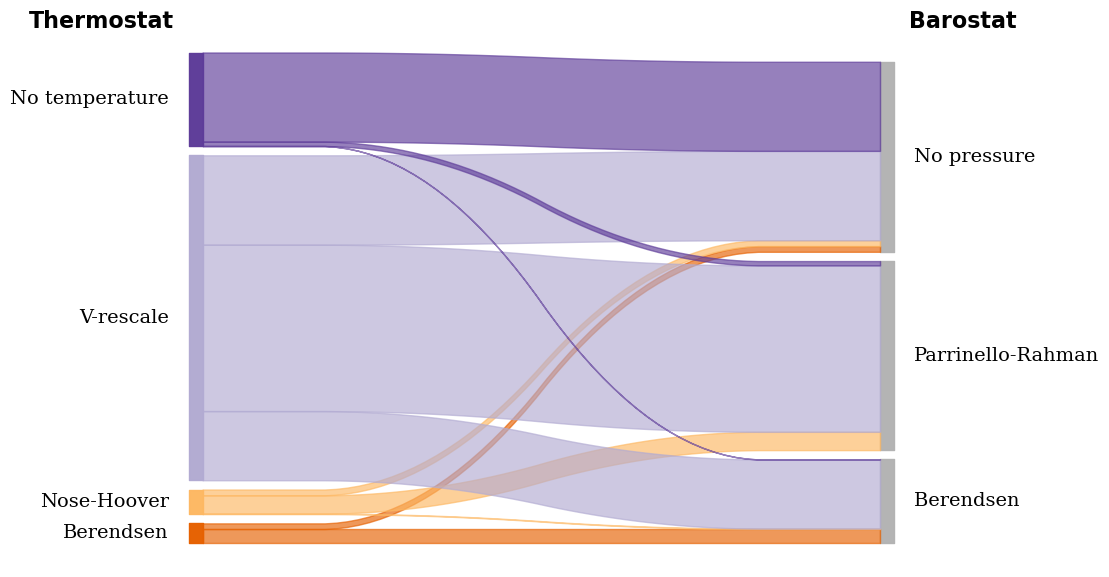

In [37]:
def plot_thermostat_barostat_sankey_graph(df):
    """Plot sankey graph with thermostats and barostats."""
    colorDict = {
        "Berendsen": "#e66101",
        "Nose-Hoover": "#fdb863",
        "V-rescale": "#b2abd2",
        "No temperature": "#5e3c99",
        "Parrinello-Rahman": "#b3b3b3",
        "No pressure": "#b3b3b3",
        "Berendsen ": "#b3b3b3",
    }
    plt.rcParams.update({"font.family":"sans-serif"})
    fig, ax = plt.subplots(figsize=(10,7))
    ax = sankey(
        df["thermostat"], df["barostat"], aspect=10, colorDict=colorDict,
        leftLabels=["Berendsen", "Nose-Hoover", "V-rescale", "No temperature"],
        rightLabels=["Berendsen ","Parrinello-Rahman","No pressure"],
        fontsize=14
    )
    plt.figtext(0.00, 0.88, "Thermostat", fontsize=16, fontweight="bold", fontfamily="sans-serif")
    plt.figtext(0.88, 0.88, "Barostat", fontsize=16, fontweight="bold", fontfamily="sans-serif")
    filename = "fig/gromacs_thermostat_barostat"
    plt.savefig(f"{filename}.png", dpi=300, bbox_inches="tight")
    plt.savefig(f"{filename}.svg", bbox_inches="tight")


plot_thermostat_barostat_sankey_graph(mdp_df)

## Watermark

In [38]:
%load_ext watermark
%watermark --python --machine
print("")
# Versions for jupyterlab, imported packages and watermark itself
%watermark --packages jupyterlab,upsetplot --iversions --watermark
# Name of conda environment
%watermark --conda

Python implementation: CPython
Python version       : 3.9.15
IPython version      : 8.6.0

Compiler    : GCC 11.2.0
OS          : Linux
Release     : 5.15.0-58-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit


jupyterlab: 3.5.2
upsetplot : 0.8.0

matplotlib: 3.5.3
numpy     : 1.24.1
pandas    : 1.5.2
yaml      : 6.0

Watermark: 2.3.1

conda environment: mdda

